In [103]:
# import packages
import pandas as pd
import seaborn as sns
import numpy as np
# from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
# myfont = FontProperties(fname='/usr/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf')

# import sys
# reload(sys)
# sys.setdefaultencoding('utf-8')

import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
# plt.plot([-1,2,-5,3])
# plt.title(u'中文',fontproperties=myfont)
# plt.show()

In [104]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

In [105]:
# load data
data_dir = '../dataset/DataFountain2019-消费者人群画像/'
train_df = pd.read_csv(data_dir + 'train_dataset.csv')
test_df = pd.read_csv(data_dir + 'test_dataset.csv')

## Data Cleaning

In [106]:
# print train_df.describe()
# print train_df.info()
print train_df.columns 
# substitue the column names
train_df.columns = ['uid','true_name_flag','age','uni_student_flag','blk_list_flag',\
                     '4g_unhealth_flag','net_age_till_now','top_up_month_diff','top_up_amount',\
                     'recent_6month_avg_use','total_account_fee','curr_month_balance',\
                     'curr_overdue_flag','cost_sensitivity','connect_num','freq_shopping_flag',\
                     'recent_3month_shopping_count','wanda_flag','sam_flag','movie_flag',\
                     'tour_flag','sport_flag','online_shopping_count','express_count',\
                     'finance_app_count','video_app_count','flight_count','train_count',\
                     'tour_app_count','score']
test_df.columns = train_df.columns[:-1]
print train_df.columns, len(train_df.columns)

Index([u'用户编码', u'用户实名制是否通过核实', u'用户年龄', u'是否大学生客户', u'是否黑名单客户', u'是否4G不健康客户',
       u'用户网龄（月）', u'用户最近一次缴费距今时长（月）', u'缴费用户最近一次缴费金额（元）', u'用户近6个月平均消费值（元）',
       u'用户账单当月总费用（元）', u'用户当月账户余额（元）', u'缴费用户当前是否欠费缴费', u'用户话费敏感度',
       u'当月通话交往圈人数', u'是否经常逛商场的人', u'近三个月月均商场出现次数', u'当月是否逛过福州仓山万达',
       u'当月是否到过福州山姆会员店', u'当月是否看电影', u'当月是否景点游览', u'当月是否体育场馆消费',
       u'当月网购类应用使用次数', u'当月物流快递类应用使用次数', u'当月金融理财类应用使用总次数', u'当月视频播放类应用使用次数',
       u'当月飞机类应用使用次数', u'当月火车类应用使用次数', u'当月旅游资讯类应用使用次数', u'信用分'],
      dtype='object')
Index([u'uid', u'true_name_flag', u'age', u'uni_student_flag',
       u'blk_list_flag', u'4g_unhealth_flag', u'net_age_till_now',
       u'top_up_month_diff', u'top_up_amount', u'recent_6month_avg_use',
       u'total_account_fee', u'curr_month_balance', u'curr_overdue_flag',
       u'cost_sensitivity', u'connect_num', u'freq_shopping_flag',
       u'recent_3month_shopping_count', u'wanda_flag', u'sam_flag',
       u'movie_flag', u'tour_flag', u'sport_flag', u'online_sh

In [107]:
# Categorical features
categorical_cols = ['4g_unhealth_flag', 'blk_list_flag', 'cost_sensitivity', 'curr_overdue_flag', 'freq_shopping_flag',
                   'movie_flag', 'tour_flag', 'sport_flag', 'sam_flag', 'true_name_flag', 
                    'wanda_flag', 'uni_student_flag']
numerical_cols = ['age', 'net_age_till_now', 'top_up_amount', 'recent_6month_avg_use',
                 'total_account_fee', 'curr_month_balance', 'connect_num', 'recent_3month_shopping_count',
                 'online_shopping_count', 'express_count', 'finance_app_count', 'video_app_count', 'flight_count',
                 'train_count', 'tour_app_count', 'top_up_month_diff']
drop_cols = ['uid', 'blk_list_flag']
target = ['score']
print len(categorical_cols), len(numerical_cols)
print len(categorical_cols)+len(numerical_cols)+len(drop_cols)+len(target)

12 16
31


In [108]:
# print train_df['age'][train_df['age']<16].value_counts()
# print train_df['age'][train_df['age']>100].value_counts()
# print set(train_df.columns.values)^set(numerical_cols)
# check the col_names are right
print set(train_df.columns.values) - set(numerical_cols) - set(categorical_cols)

set(['score', 'uid'])


## Feature Engineering


### 1. feature value processing

#### 1.1 age
看到有 age 为0和超过100的用户，这一部分的用户很明显信息是不准确的，那么在一定程度上来讲，他们的信用分不会太高。那么把他们处理成平均年龄。

改了反而得分降低了，线上线下都有降低，所以不能这么处理，在查看了 test_df 中也是有类似的情况后，就采取保留措施。

In [109]:
# train_df['age'][train_df['age']<6] = train_df['age'].mean()
# train_df['age'][train_df['age']>100] = train_df['age'].mean()

##### 1.2  '缴费用户最近一次缴费金额（元）'--(top_up_amount)
通过 EDA 知道，这个特征与 score_qcut 强线性相关。观察看到充值数字有整数和小数，可能是充值方式不同，作为一个新特征试一下，

In [110]:
def produce_top_up_amount_feat(data_df):
    data_df['top_up_amount_new'] = 0
    data_df['top_up_amount_new'][(data_df['top_up_amount'] % 10 == 0) & (data_df['top_up_amount'] != 0)] = 1
    return data_df

### 2. 数值特征的简单变换 Feature Construction


#### 2.1 ratio feature
###### 2.1.1 top_up_amount / curr_month_balance
'缴费用户最近一次缴费金额（元）'/'用户当月账户余额（元）'--(top_up_amount) / curr_month_balance 充值金额和当前月的比例

这个特征并没有什么提升。

In [111]:
def produce_amount_balance_ratio_feat(data_df):
    data_df['amount_balance_ratio'] = data_df['top_up_amount'] / (data_df['curr_month_balance'] + 1)
    return data_df

###### 2.1.2 total_account_fee / curr_month_balance
'用户账单当月总费用（元）'/ '用户当月账户余额（元）' (total_account_fee/curr_month_balance)

有一定提升

In [112]:
def produce_fee_balance_ratio_feat(data_df):
    data_df['fee_balance_ratio'] = data_df['total_account_fee'] / (data_df['curr_month_balance'] + 1)
    return data_df

##### 2.1.3 total_account_fee / recent_6month_avg_use
'用户账单当月总费用（元）'/ '用户近6个月平均消费值（元）'（total_account_fee/recent_6month_avg_use）

有较大提升。

In [113]:
# def produce_amount_use_ratio_feat(data_df):
#     data_df['amount_use_ratio'] = data_df['total_account_fee'] / (data_df['recent_6month_avg_use'] + 1)
#     return data_df

##### 2.1.4 age / net_age_till_now
'用户年龄'/ '用户网龄（月）'（total_account_fee/recent_6month_avg_use）

In [114]:
def produce_age_net_ratio_feat(data_df):
    data_df['age_net_ratio'] = data_df['age'] * 12 / (data_df['net_age_till_now'] + 1)
    return data_df

###### 2.1.5 total_account_fee / top_up_amount
'用户账单当月总费用（元）'/ '缴费用户最近一次缴费金额（元）' (total_account_fee/top_up_amount)

线下有较大提升

In [115]:
def produce_fee_top_ratio_feat(data_df):
    data_df['fee_top_ratio'] = data_df['total_account_fee'] * 12 / (data_df['top_up_amount'] + 1)
    return data_df

###### 2.1.6 recent_6month_avg_use / top_up_amount
 '用户近6个月平均消费值（元）'/ '缴费用户最近一次缴费金额（元）' (recent_6month_avg_use / top_up_amount)

In [116]:
def produce_use_top_ratio_feat(data_df):
    data_df['use_top_ratio'] = data_df['recent_6month_avg_use'] * 12 / (data_df['top_up_amount'] + 1)
    return data_df

###### 2.1.7 recent_6month_avg_use / curr_month_balance
 '用户近6个月平均消费值（元）'/ '用户当月账户余额（元）' (recent_6month_avg_use / curr_month_balance)

In [117]:
def produce_use_balance_ratio_feat(data_df):
    data_df['use_balance_ratio'] = data_df['recent_6month_avg_use'] * 12 / (data_df['curr_month_balance'] + 1)
    return data_df

In [118]:
# combine the ratio features
def produce_ratio_feats(data_df):
    # 2.1.1 '缴费用户最近一次缴费金额（元）'/'用户当月账户余额（元） top_up_amount / curr_month_balance
    data_df = produce_amount_balance_ratio_feat(data_df)
    
    # 2.1.2 '用户账单当月总费用（元）'/ '用户当月账户余额（元）'  total_account_fee / curr_month_balance
    data_df = produce_fee_balance_ratio_feat(data_df)
    
    # 2.1.3 '用户账单当月总费用（元）'/ '用户近6个月平均消费值  top_up_amount / recent_6month_avg_use
#     data_df = produce_amount_use_ratio_feat(data_df)
    
    # 2.1.4 '用户年龄'/ '用户网龄（月）'  age / net_age_till_now
    data_df = produce_age_net_ratio_feat(data_df)
    
    # 2.1.5 total_account_fee / top_up_amount
    data_df = produce_fee_top_ratio_feat(data_df)
    
    # 2.1.6 recent_6month_avg_use / top_up_amount
    data_df = produce_use_top_ratio_feat(data_df)
    
    # 2.1.7 recent_6month_avg_use / curr_month_balance
#     data_df = produce_use_balance_ratio_feat(data_df)
    return data_df

### 3. 类别特征与数值特征的组合

#### 2.2 add features


In [119]:
# 缴费用户最近一次缴费金额（元） 整数 or not
train_df = produce_top_up_amount_feat(train_df)
test_df = produce_top_up_amount_feat(test_df)

In [120]:
train_df = produce_ratio_feats(train_df)
test_df = produce_ratio_feats(test_df)

## Training

In [121]:
# LightGBM params
params = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mae',
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'num_leaves': 31,
    'verbose': -1,
    'max_depth': 5,
    'lambda_l2': 5, 'lambda_l1': 0
}

In [122]:
# drop useless features
print train_df.columns, len(train_df.columns)
X = train_df.drop(drop_cols + ['score'], axis=1)
X_submit = test_df.drop(drop_cols, axis=1)

Index([u'uid', u'true_name_flag', u'age', u'uni_student_flag',
       u'blk_list_flag', u'4g_unhealth_flag', u'net_age_till_now',
       u'top_up_month_diff', u'top_up_amount', u'recent_6month_avg_use',
       u'total_account_fee', u'curr_month_balance', u'curr_overdue_flag',
       u'cost_sensitivity', u'connect_num', u'freq_shopping_flag',
       u'recent_3month_shopping_count', u'wanda_flag', u'sam_flag',
       u'movie_flag', u'tour_flag', u'sport_flag', u'online_shopping_count',
       u'express_count', u'finance_app_count', u'video_app_count',
       u'flight_count', u'train_count', u'tour_app_count', u'score',
       u'top_up_amount_new', u'amount_balance_ratio', u'fee_balance_ratio',
       u'age_net_ratio', u'fee_top_ratio', u'use_top_ratio'],
      dtype='object') 36


In [123]:
# k-cv
N_FOLDS = 5
y = train_df['score']
kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=2019)
kf = kfold.split(X, y)

In [124]:
# process the k-cv
cv_pred = np.zeros(test_df.shape[0])
valid_best_l2_all = 0

feature_importance_df = pd.DataFrame()
count = 0
for i, (train_idx, test_idx) in enumerate(kf):
    print('fold: ',i, ' training')
    X_train, X_test, y_train, y_test = X.iloc[train_idx, :], X.iloc[test_idx, :], y.iloc[train_idx], y.iloc[test_idx]
    data_train = lgb.Dataset(X_train, y_train)
    data_test = lgb.Dataset(X_test, y_test)
    lgb_model = lgb.train(params, data_train, num_boost_round=10000, valid_sets=data_test, 
                          verbose_eval=-1, early_stopping_rounds=50)
    cv_pred = lgb_model.predict(X_submit, num_iteration=lgb_model.best_iteration)
    valid_best_l2_all += lgb_model.best_score['valid_0']['l1']
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = list(X_train.columns)
    fold_importance_df["importance"] = lgb_model.feature_importance(importance_type='gain', iteration=lgb_model.best_iteration)
    fold_importance_df["fold"] = count + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    count += 1
    
cv_pred /= N_FOLDS
valid_best_l2_all /= N_FOLDS
print('cv score for valid is: ', 1/(1+valid_best_l2_all))

('fold: ', 0, ' training')
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2205]	valid_0's l1: 14.8327
('fold: ', 1, ' training')
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2348]	valid_0's l1: 14.712
('fold: ', 2, ' training')
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2462]	valid_0's l1: 14.813
('fold: ', 3, ' training')
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2906]	valid_0's l1: 14.518
('fold: ', 4, ' training')
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3313]	valid_0's l1: 14.8468
('cv score for valid is: ', 0.063514265393465136)


In [125]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

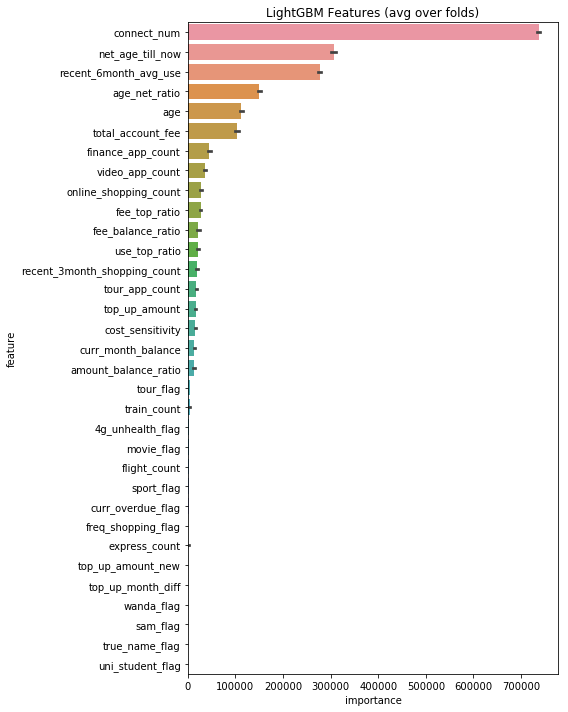

In [126]:
display_importances(feature_importance_df)

## Submit

In [127]:
submit_df = test_df[['uid']]
submit_df['score'] = cv_pred
submit_df.columns = ['id', 'score']

# int
submit_df['score'] = submit_df['score'].apply(lambda x: int(np.round(x)))
submit_df.to_csv('./submission/baseline_2019-03-01T07:45:47_0.063514265393465136.csv', index=False)

In [77]:
submit_df.head(10)

,id,score
0,7171737d49b143d1b38883a39e4a5730,121
1,3af0a449d5424488912e8fb2bf4b9faa,107
2,eb2cf02e0d5c4d1294dd73e776dbb441,134
3,9c0f780ecb254670a11aa9e3f10777c5,135
4,d794eed46c1e44f785a575f18b3023a5,131
5,18f6a7d824a1421b9da3e5f10854c3df,123
6,e7b63888a36f499a88811c0936bb12df,128
7,f995ef4d96fc426191a104421b0f5b20,115
8,11a3ce45ce234f7db4e91e5f152dc8b8,135
9,86ebeac087284c87bbcb1281d95ef9eb,116


In [46]:
# data_dummies = pd.get_dummies(train_df[numerical_cols])
# data_dummies.head(20)